# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [25]:
import cv2
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import pandas as pd
import pickle
import pylab
import time

from matplotlib.pyplot import *
from PIL import Image
from pprint import pprint
from sklearn.utils import shuffle



# Visualizations will be shown in the notebook.
%matplotlib inline

---
## Step 0: Load The Data

In [26]:
training_file = 'train.p'
validation_file='valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


### Basic Summary of the Data Set

In [27]:
# Number of training examples
n_train = len(X_train)

# Number of testing examples.
n_test = len(y_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

In [28]:
#lets review the label structure
label_names = pd.read_csv('signnames.csv')
list(label_names.columns.values)

['ClassId', 'SignName']

In [29]:
import pylab
def display_uniques(data):
    pylab.rcParams['figure.figsize'] = (40, 40)

    label_type=[]

    for i  in  range(0,n_classes):
        plt.subplot(10,5,i+1)
        plt.subplots_adjust(hspace=.5, wspace=.5)
        label_type.append(data[np.where( y_test == i )[0][0],:,:,:].squeeze())
        lbel =label_names.SignName[i]
        #lbel = "{0}".format(i+1)
        plt.xlabel("{0}: ".format(i)+lbel, fontsize=20)
        plt.imshow(data[np.where( y_test == i )[0][0],:,:,:].squeeze(),cmap="gray")
        plt.xticks([])
        plt.yticks([])
    plt.show()

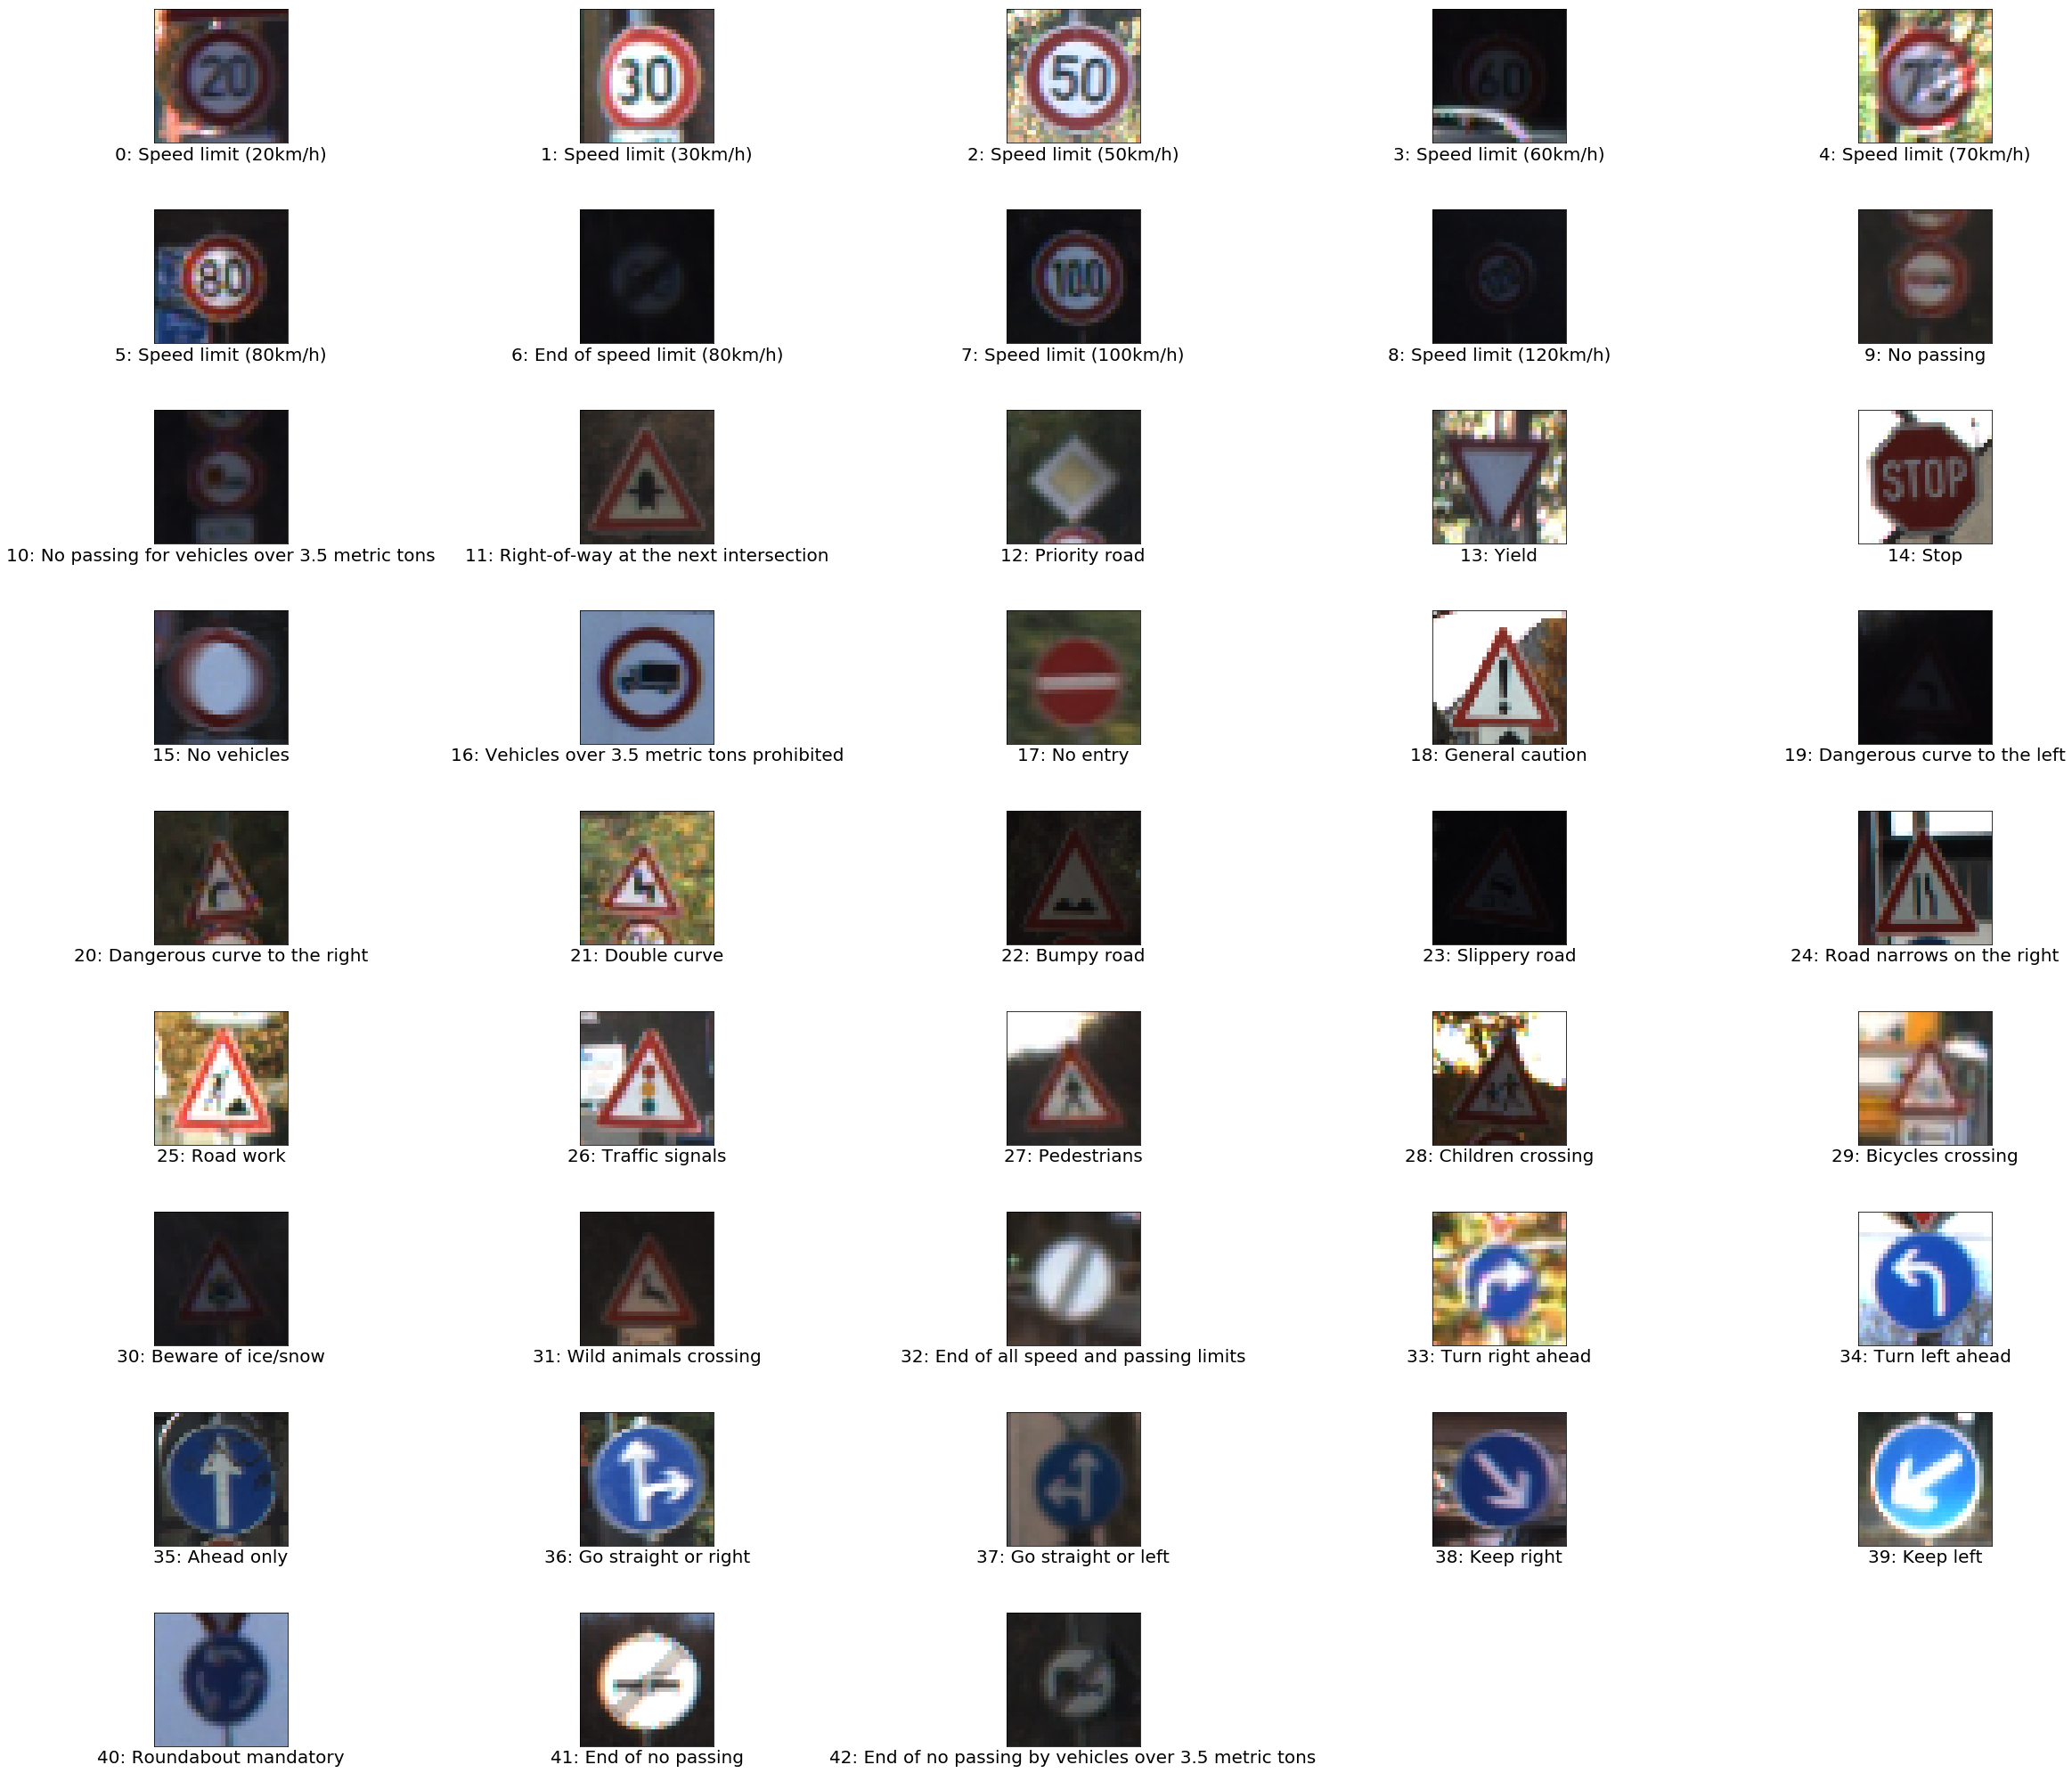

In [94]:
#now lets see each unique class Image with their corresponding Label.
display_uniques(X_test)

### Number of samples per class in the train set

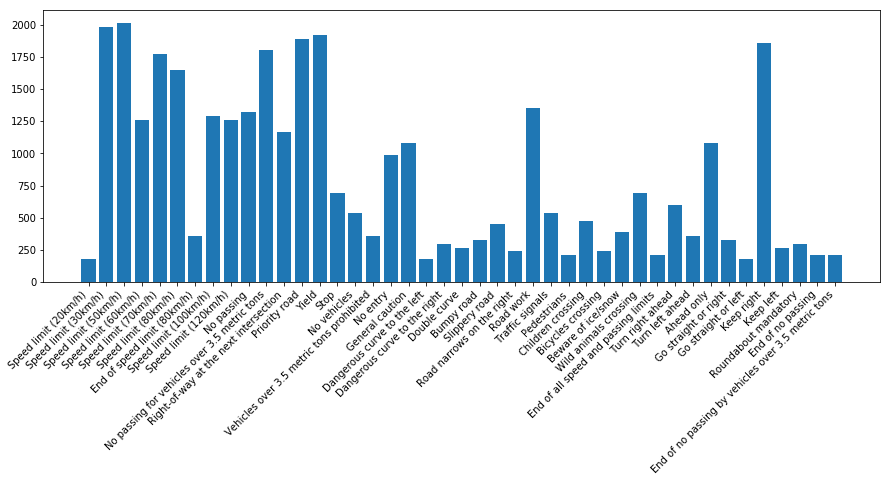

In [7]:
grouped_ds = dict()
def dataset_stats(X_train):
    stats = dict()
    for i,image in enumerate(X_train):
        if y_train[i] not in stats:
            stats[y_train[i]] = 0
            grouped_ds[y_train[i]] = []
        else:
            stats[y_train[i]] = stats[y_train[i]] + 1
            grouped_ds[y_train[i]].append(image)
    return stats
        
stats = dataset_stats(X_train)
plt.figure(figsize=(15,5))
plt.bar(range(len(stats)), stats.values())
label =label_names.SignName
plt.xticks(range(len(stats)), label, ha='right', rotation=45)
plt.show()


On the chart [number of samples per class] we can see chart above that we have a considerate difference between the number of samples

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set (normalization, grayscale, etc.)

In [30]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def normalize(img):
    """Normalize the data from 0 to 1
    """
    return img.astype(float) / 255.0

In [9]:
#Convert the image from RGB to GRAY channel
X_train_gray = []
X_test_gray = []
X_validation_gray = []

for image in X_train:
    X_train_gray.append(normalize(grayscale(image)))
X_train_1 = np.array(X_train_gray).reshape((-1,32,32,1))    

for image in X_test:
    X_test_gray.append(normalize(grayscale(image)))
X_test_1 = np.array(X_test_gray).reshape((-1,32,32,1))

for image in X_validation:
    X_validation_gray.append(normalize(grayscale(image)))
X_validation_1 = np.array(X_validation_gray).reshape((-1,32,32,1))


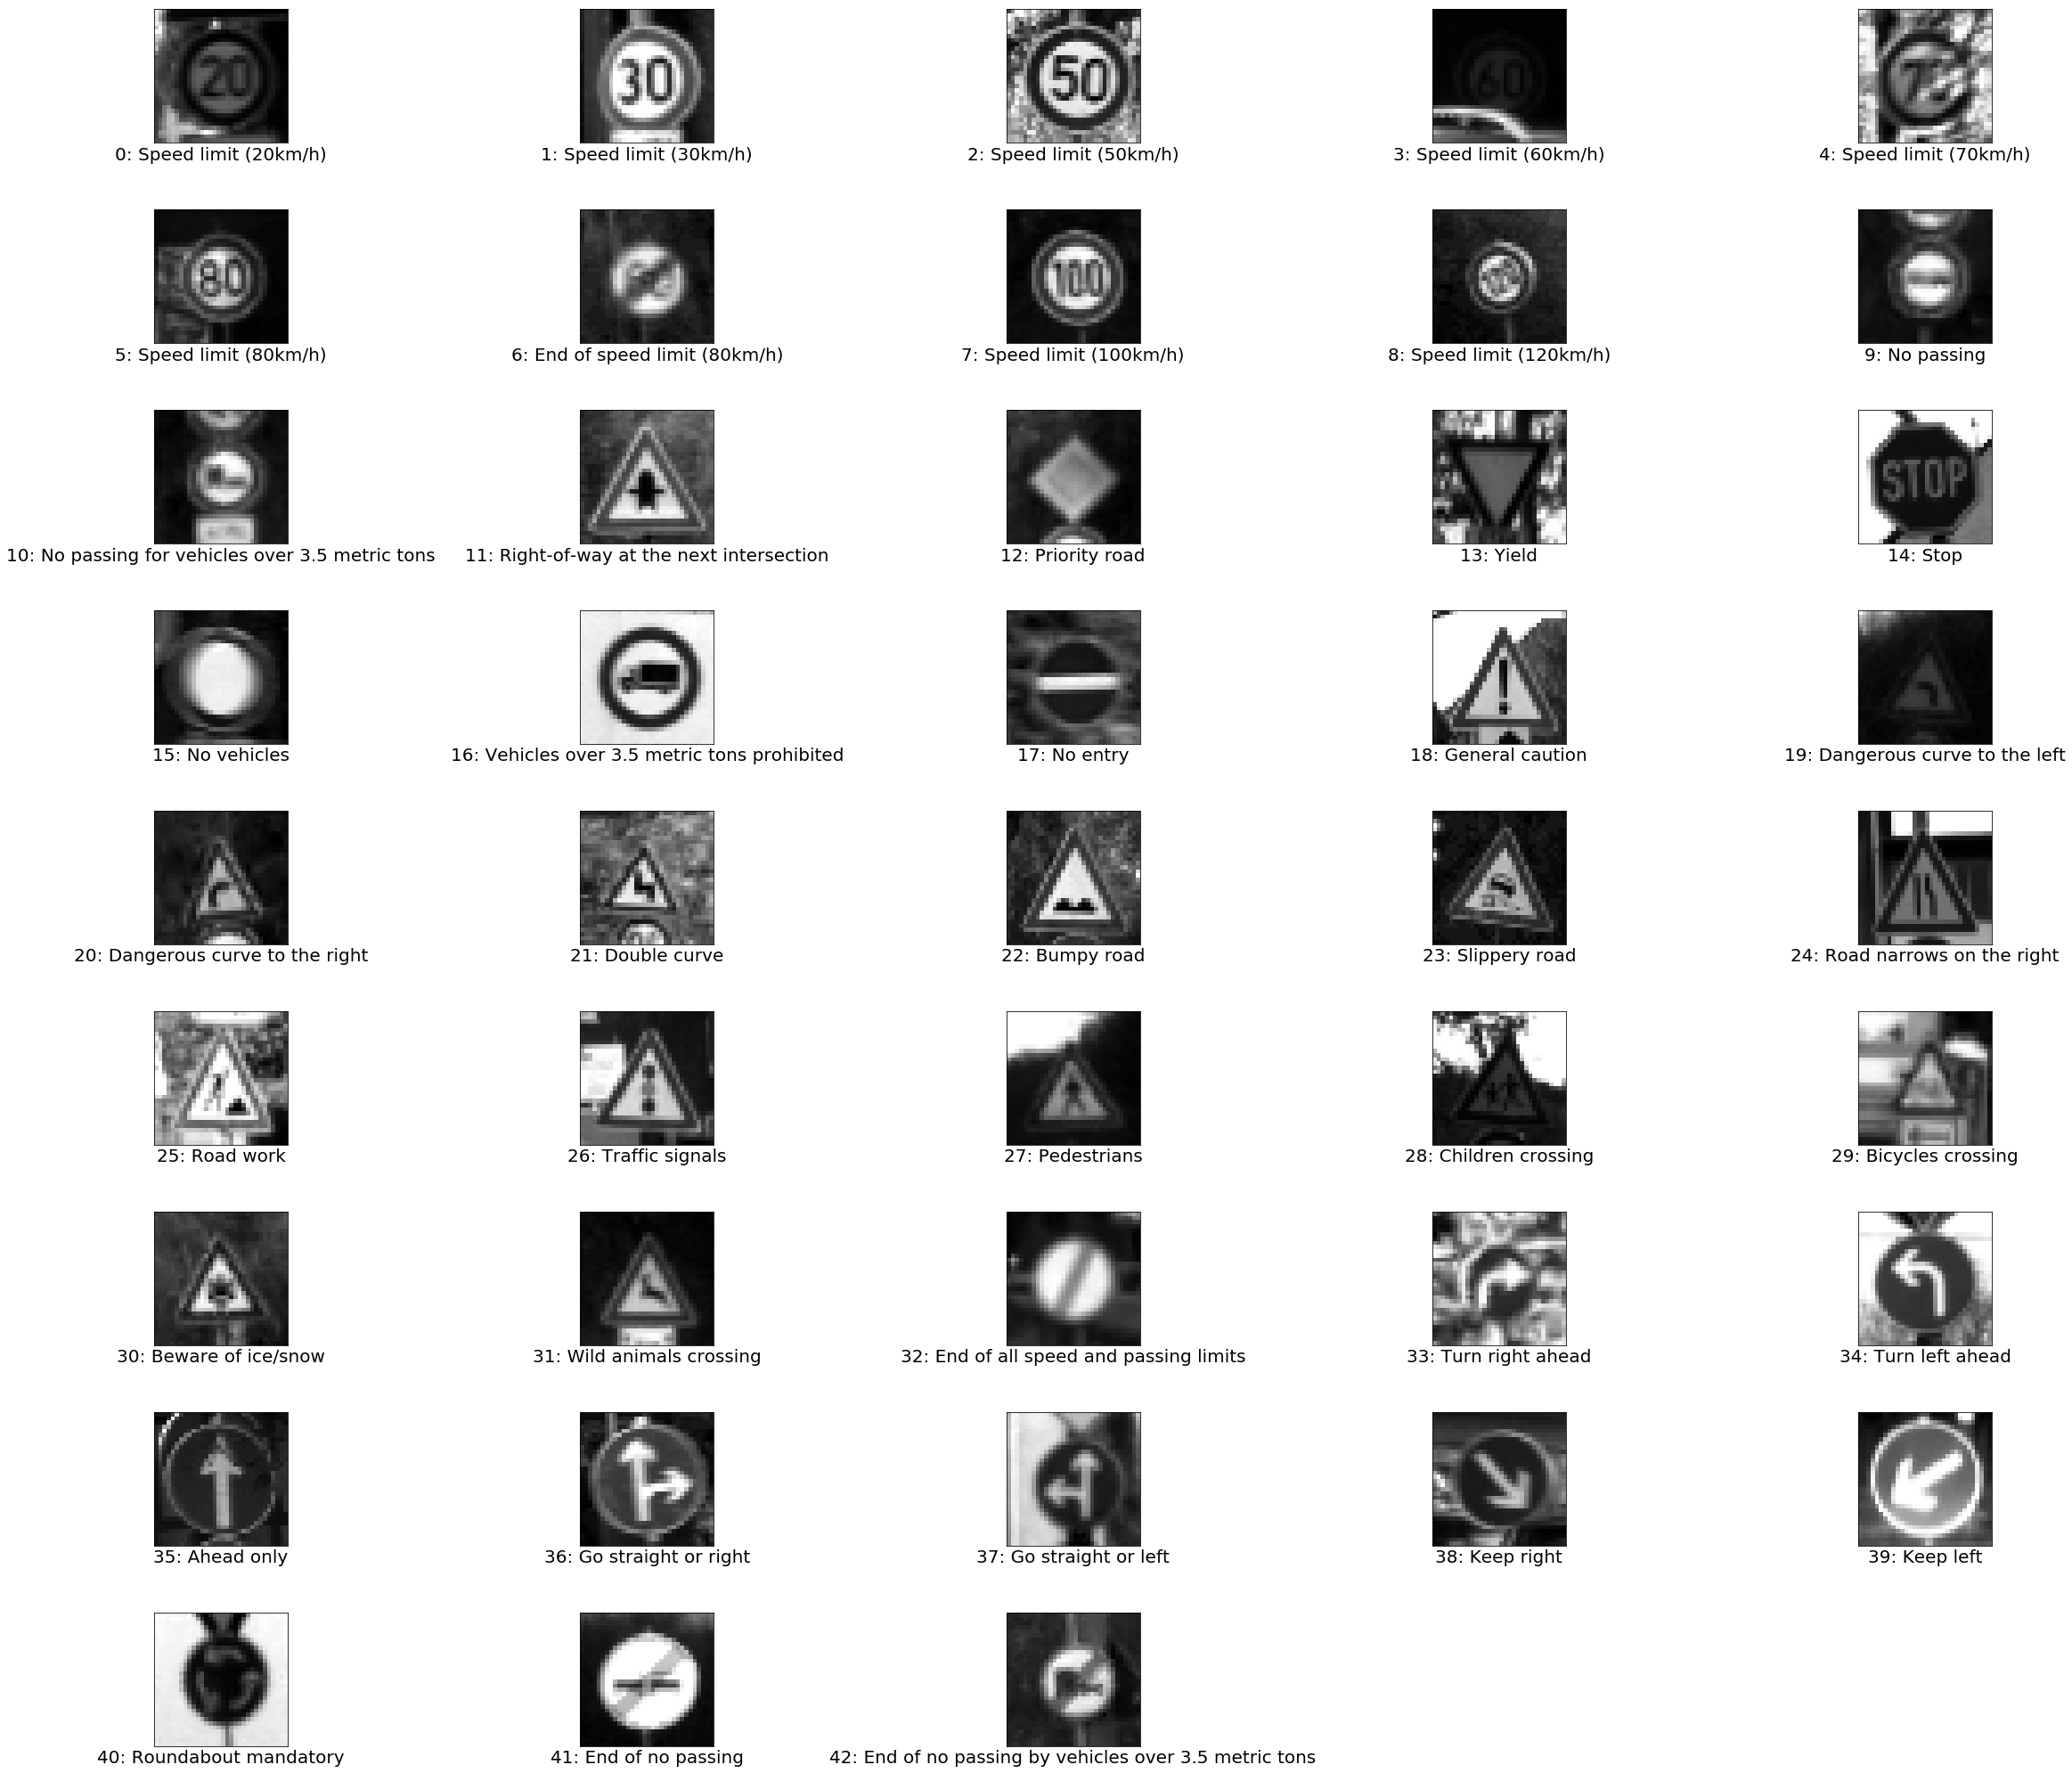

In [77]:
#now lets see each unique class Image with their corresponding Label.
display_uniques(X_test_1, y_test)

### Save processed dataset

In [11]:
prepro_dataset = {
    "features" : X_train_1,
    "labels"   : y_train
}

prepro_test_dataset = {
    "features" : X_test_1,
    "labels"   : y_test
}

prepro_validation_dataset = {
    "features" : X_validation_1,
    "labels"   : y_validation
}


file_prepro = open('processed_train.pickle', 'wb') 
pickle.dump(prepro_dataset, file_prepro, protocol=4)

file_prepro_test = open('processed_test.pickle', 'wb') 
pickle.dump(prepro_test_dataset, file_prepro_test, protocol=4)

file_prepro_validation = open('processed_validation.pickle', 'wb') 
pickle.dump(prepro_validation_dataset, file_prepro_validation, protocol=4)

## Load preprocessed dataset

In [12]:
# Load pickled data
with open("processed_train.pickle", mode='rb') as f:
    X_train_p = pickle.load(f)
with open("processed_test.pickle", mode='rb') as f:
    X_test_p = pickle.load(f)
with open("processed_validation.pickle", mode='rb') as f:
    X_validation_p = pickle.load(f)

In [13]:
X_train, y_train = X_train_p['features'], X_train_p['labels']
X_test, y_test = X_test_p['features'], X_test_p['labels']
X_validation, y_validation = X_validation_p['features'], X_validation_p['labels']

### Model Architecture

### Input
* The proposed architecture accepts a 32x32xC image as input. where C is 1 since its grayscale 

### Architecture
* **Layer 1: Convolutional.** Output shape 28x28x6.
* **Activation.** computes rectified linear.

* **Pooling.** Output shape should be 14x14x6.
* **Layer 2: Convolutional.** The output shape should be 10x10x16.
* **Activation.** Compute rectified linear.
* **Pooling.**  Output shape 5x5x16.
* **Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D.
* **Layer 3: Fully Connected.**  120 outputs.
* **Activation.** compute rectified linear.
* **Layer 4: Fully Connected.**  84 outputs.
* **Activation.** compute rectified linear.
* **Dropout.** Compute dropout.
* **Layer 5: Fully Connected (Logits).** This should have 43 outputs.
### Output
* Return the result of the last fully connected layer.


based on LeNet-5 architecture [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.

### Setup TensorFlow

In [31]:
import tensorflow as tf

EPOCHS = 30
BATCH_SIZE = 128
dropout = 0.75
C= 1
save_file = 'train_model.ckpt'

In [32]:
from tensorflow.contrib.layers import flatten

def LeNet(x, dropout):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    #Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, C, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    #Activation.
    conv1 = tf.nn.relu(conv1)

    #Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    #Activation relu
    conv2 = tf.nn.relu(conv2)

    #Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    #Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    #Activation relu
    fc1    = tf.nn.relu(fc1)

    #Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    #Activation relu
    fc2    = tf.nn.relu(fc2)

    #Activation dropout
    fc2 = tf.nn.dropout(fc2, dropout)
    
    # Layer 5: Fully Connected. Input = 84. Output = 430.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [33]:
### features
x = tf.placeholder(tf.float32, (None, 32, 32, C))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

### Train, Validate and Test the Model

In [34]:
#training pipeline
rate =0.001

logits = LeNet(x,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits( logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)


In [35]:
#model evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data, prob):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:prob})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [19]:
#Train the model
accu = dict()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : dropout })
            
        validation_accuracy = evaluate(X_validation, y_validation, 1.0)
        accu[i] = validation_accuracy
        print('Epoch: {:<4} Valid Accuracy: {:<5.3} '.format(i+1,validation_accuracy))

    saver.save(sess, save_file)
    print("Model saved")

Training...

Epoch: 1    Valid Accuracy: 0.663 
Epoch: 2    Valid Accuracy: 0.826 
Epoch: 3    Valid Accuracy: 0.858 
Epoch: 4    Valid Accuracy: 0.891 
Epoch: 5    Valid Accuracy: 0.903 
Epoch: 6    Valid Accuracy: 0.904 
Epoch: 7    Valid Accuracy: 0.913 
Epoch: 8    Valid Accuracy: 0.917 
Epoch: 9    Valid Accuracy: 0.915 
Epoch: 10   Valid Accuracy: 0.927 
Epoch: 11   Valid Accuracy: 0.925 
Epoch: 12   Valid Accuracy: 0.923 
Epoch: 13   Valid Accuracy: 0.927 
Epoch: 14   Valid Accuracy: 0.929 
Epoch: 15   Valid Accuracy: 0.935 
Epoch: 16   Valid Accuracy: 0.922 
Epoch: 17   Valid Accuracy: 0.923 
Epoch: 18   Valid Accuracy: 0.926 
Epoch: 19   Valid Accuracy: 0.924 
Epoch: 20   Valid Accuracy: 0.927 
Epoch: 21   Valid Accuracy: 0.93  
Epoch: 22   Valid Accuracy: 0.933 
Epoch: 23   Valid Accuracy: 0.933 
Epoch: 24   Valid Accuracy: 0.935 
Epoch: 25   Valid Accuracy: 0.936 
Epoch: 26   Valid Accuracy: 0.938 
Epoch: 27   Valid Accuracy: 0.929 
Epoch: 28   Valid Accuracy: 0.941 
Epoch: 

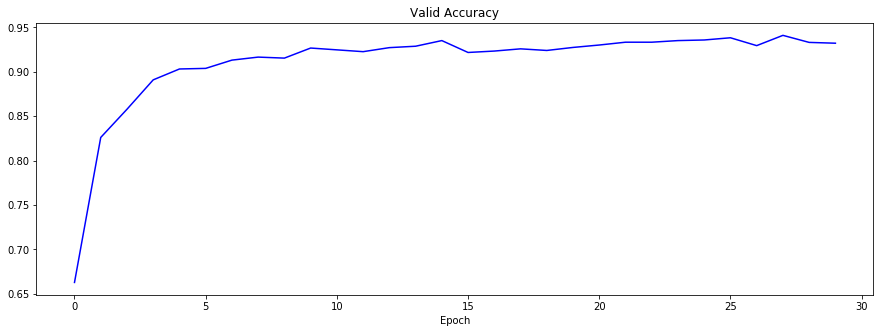

In [20]:
plt.figure(figsize=(15,5))
plt.plot(list(accu.keys()), list(accu.values()), color='b')
plt.xlabel('Epoch')
plt.title('Valid Accuracy')
plt.autoscale(enable=True, axis='both', tight=None)
plt.show()

## Evaluate The Model

In [21]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test, 1.0)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.917


## Step 3: Test a Model on New Images

### Load and Output the Images

In [4]:
import glob
import cv2
extra_images = glob.glob('*.jpg')

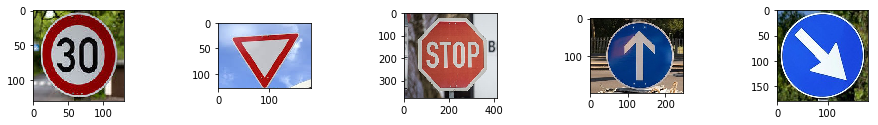

In [5]:
#now lets see each unique class Image with their corresponding Label.
pylab.rcParams['figure.figsize'] = (15, 15)

for i, image in enumerate(extra_images):
    plt.subplot(5,5,i+1)
    img=plt.imread(image)
    plt.subplots_adjust(hspace=1, wspace=1)
    plt.imshow(img)
plt.show()

### Resize images

In [6]:
# Read sample image files, resize them, convert to numpy arrays w/ dtype=uint8
image_files  = glob.glob('*.jpg') 
new_X = []
for image_file in image_files:
    image = Image.open(image_file)
    image = image.convert('RGB')
    image = image.resize((32, 32), Image.ANTIALIAS)
    image = np.array(list(image.getdata()), dtype='uint8')
    image = np.reshape(image, (32, 32, 3))
    new_X.append(image)
new_X = np.array(new_X, dtype='uint8')

In [9]:
gray=[]
for image in new_X:
    gray.append(normalize(grayscale(image)))
new_X_gray = np.array(gray).reshape((-1,32,32,1))    


In [10]:
#new_X_gray_labels =['14','15','2','35','36']
new_X_gray_labels = []
for file in image_files:
    new_X_gray_labels.append(os.path.splitext(file)[0])

### Predict the Sign Type for Each Image and Analyze performance

In [36]:
classify_operation = tf.argmax(logits, 1)
soft = tf.nn.softmax(logits)
new_y = np.zeros(n_classes)

with tf.Session() as sess:
    saver.restore(sess,  tf.train.latest_checkpoint('.'))
    index = sess.run(classify_operation, feed_dict={x: new_X_gray, y: new_X_gray_labels, keep_prob: 1.0})
    
    res = sess.run(correct_prediction, feed_dict={x : new_X_gray, y : new_X_gray_labels, keep_prob : 1.0})
    test_accuracy = evaluate(new_X_gray,  new_X_gray_labels, 1.0)
    
    print("Accuracy {:.3f}".format(test_accuracy))
    print("Prediction {}".format(res))
    print(image_files)
    print(index)

Accuracy 1.000
Prediction [ True  True  True  True  True]
['1.jpg', '13.jpg', '14.jpg', '35.jpg', '38.jpg']
[ 1 13 14 35 38]


#### this model has 100% accuracy on new images

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

### The top five softmax probabilities for the predictions on the German traffic sign images found on the web. 


In [37]:
#classify_operation = tf.argmax(logits, 1)
soft = tf.nn.softmax(logits)
new_y = np.zeros(n_classes)
top_K = tf.nn.top_k(soft,5)

with tf.Session() as sess:
    saver.restore(sess,  tf.train.latest_checkpoint('.'))
    #index = sess.run(classify_operation, feed_dict={x: new_X_gray, y: new_X_gray_labels, keep_prob: 1.0})
    
    res = sess.run(correct_prediction, feed_dict={x : new_X_gray, y : new_X_gray_labels, keep_prob : 1.0})
    top_prob, top_pred = sess.run(top_K, feed_dict={x : new_X_gray, y : new_X_gray_labels, keep_prob : 1.0})
    test_accuracy = evaluate(new_X_gray,  new_X_gray_labels, 1.0)

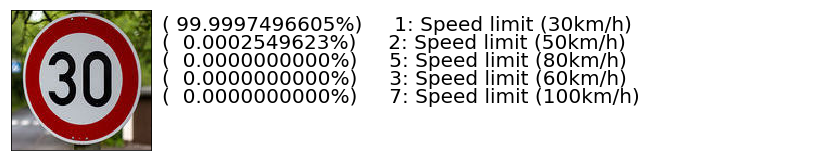

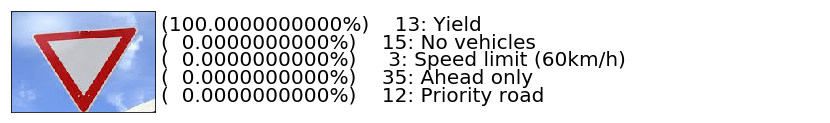

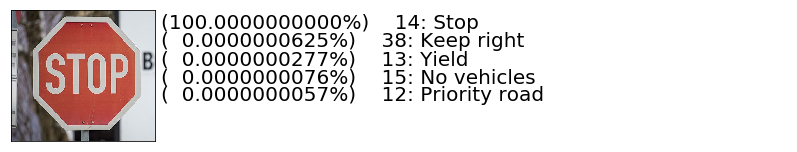

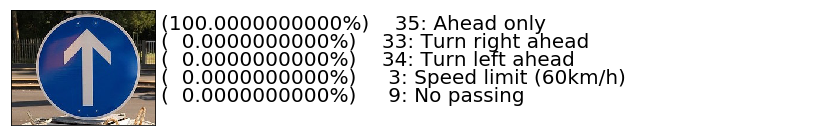

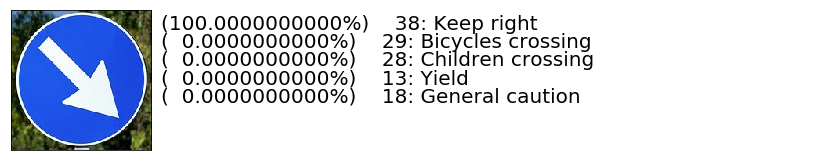

In [43]:
pylab.rcParams['figure.figsize'] = (15, 15)
for i, (preds, probs, image) in enumerate(zip(top_pred, top_prob, extra_images)):
    img=plt.imread(image)
    plt.subplot(5,5,i+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    j=0
    for  pred, prob in zip(preds.astype(int), probs):
        j+=3
        sign_name = label_names.SignName[pred]
        leg=('({:>14.10f}%) {:>5}: {:<50} '.format(prob*100.0, pred, sign_name ))
        plt.annotate(leg, fontsize=20, xy=(.25, 1.2),
                    xycoords='data', xytext=(150, -6*j),
                    textcoords='offset points')
    plt.show()  

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [133]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 